In [525]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)


sys.path.append('../')
import xai
from xai.xdata import XData
from importlib import reload
reload(xai)
reload(xai.xdata)
import xai
from xai.xdata import XData

In [526]:
csv_path = 'data/adult.data'
csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country", "loan"]

In [527]:
df = pd.read_csv(csv_path, names=csv_columns)

In [528]:
xd = XData(df)
xd.df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


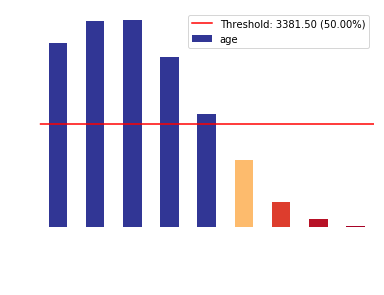

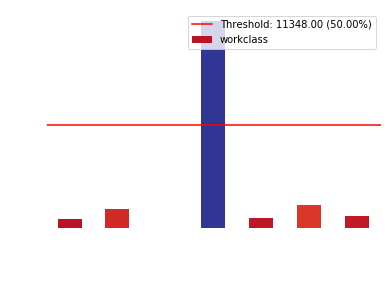

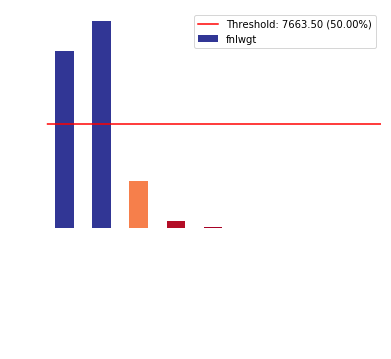

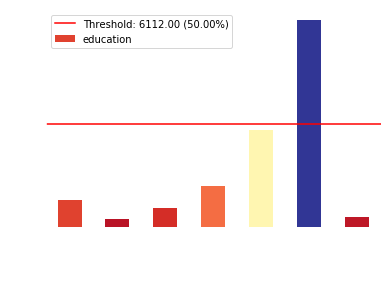

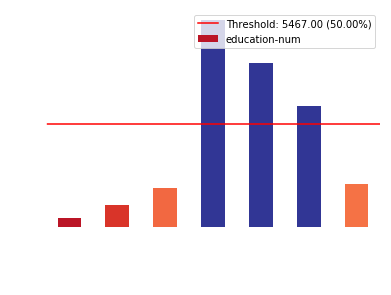

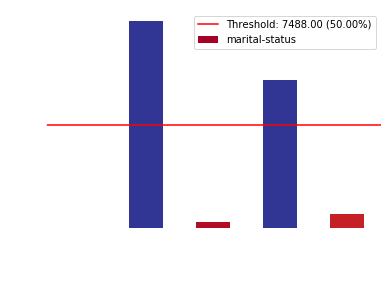

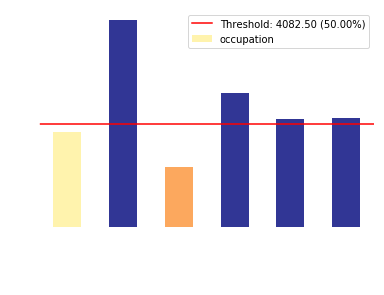

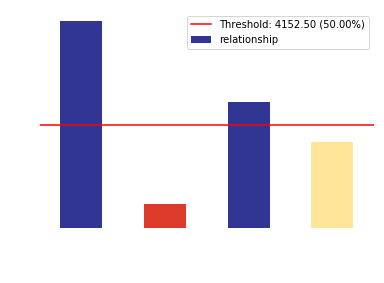

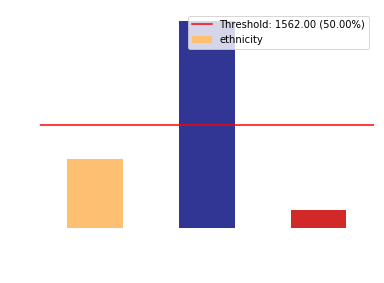

ValueError: zero-size array to reduction operation maximum which has no identity

In [496]:
xd.imbalances()

In [490]:
xd.imbalance("gender")


<function math.ceil>

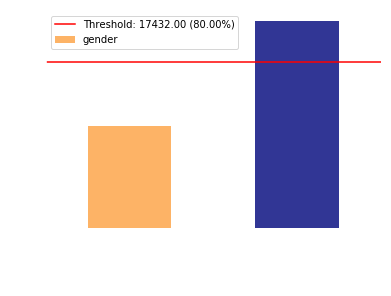

In [411]:
xd.set_threshold(0.8)
xd.imbalance("gender")

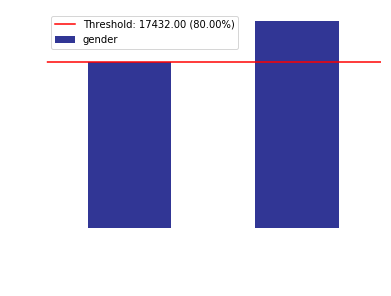

In [412]:
xd.balance("gender")
xd.imbalance("gender")

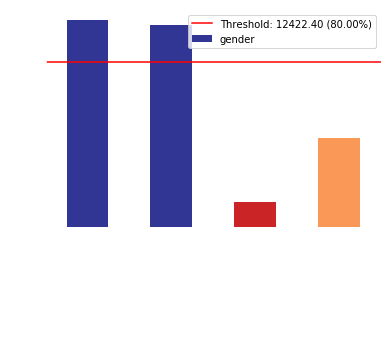

In [413]:
xd.imbalance("gender", cross_column_names=["loan"])

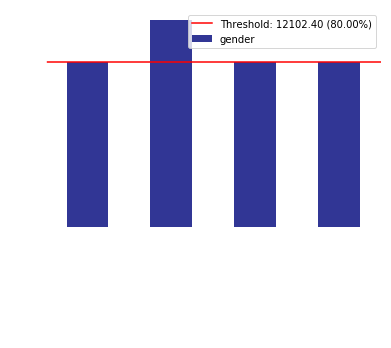

In [414]:
xd.reset()
xd.balance("gender", cross_column_names=["loan"])
xd.imbalance("gender", cross_column_names=["loan"])

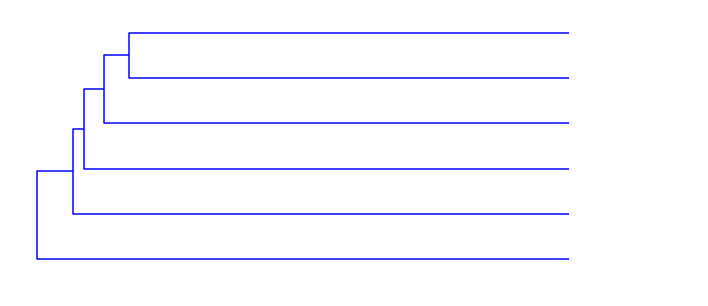

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.0000,-0.0766,0.0365,0.0777,0.0578,0.0688
fnlwgt,-0.0766,1.0000,-0.0432,0.0004,-0.0103,-0.0188
education-num,0.0365,-0.0432,1.0000,0.1226,0.0799,0.1481
capital-gain,0.0777,0.0004,0.1226,1.0000,-0.0316,0.0784
capital-loss,0.0578,-0.0103,0.0799,-0.0316,1.0000,0.0543
hours-per-week,0.0688,-0.0188,0.1481,0.0784,0.0543,1.0000


In [501]:
xd.correlations()

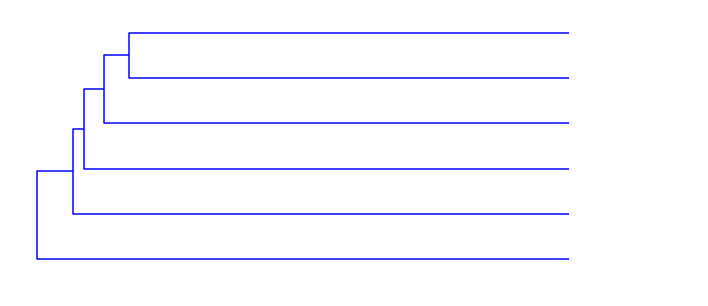

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000


In [530]:
xd.correlations()

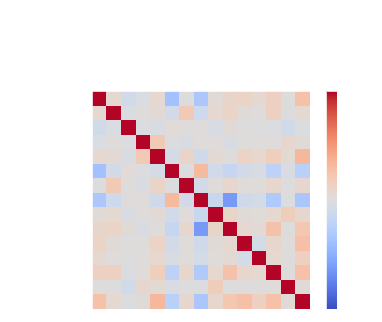

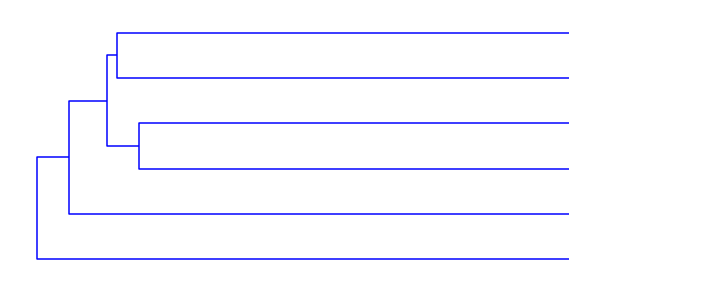

In [508]:
import scipy
import scipy.stats as sts
from scipy.cluster import hierarchy as hc

def plot_dendogram(X):
    corr = np.round(X.corr(method="spearman"), 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method="average")
    fig = plt.figure(figsize=(10,5))
    dendrogram = hc.dendrogram(
        z, labels=X.columns, orientation="left", leaf_font_size=16)
    plt.show()
    
    
corr = sts.spearmanr(df).correlation
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()
    
plot_dendogram(df)

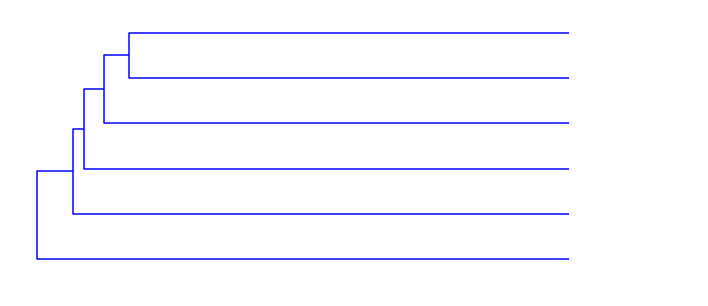

In [532]:
corr = xd.correlations()

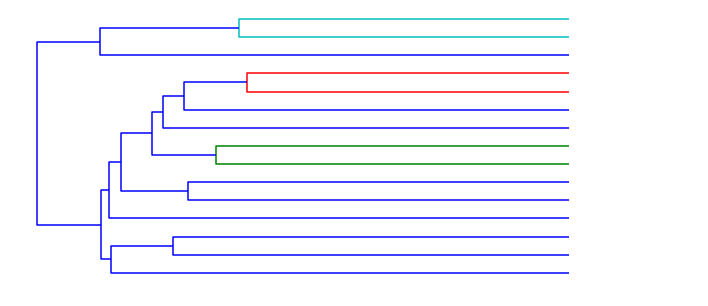

In [533]:
corr = xd.correlations(include_categorical=True)

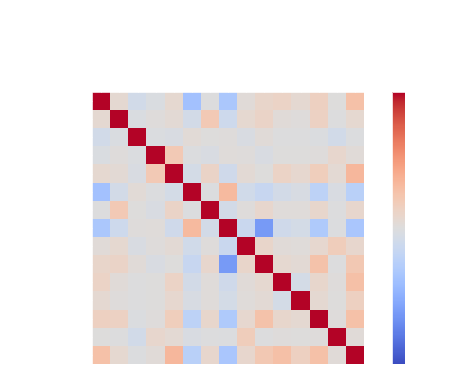

In [534]:
corr = xd.correlations(include_categorical=True, plot_type="matrix")

In [555]:
import seaborn as sns
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


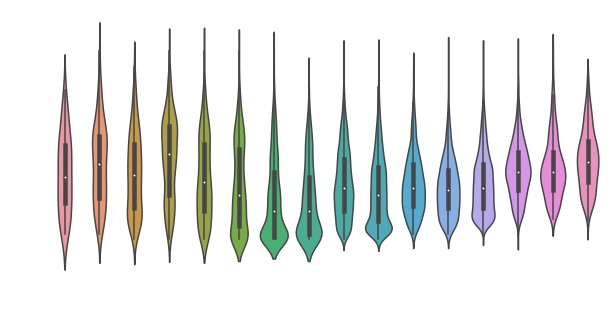

In [585]:
a4_dims = (10,5)
fig, ax = plt.subplots(figsize=a4_dims)
sn.violinplot(x='education-num', y='age', data=df, ax=ax)

/home/alejandro/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/alejandro/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/home/alejandro/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/home/alejandro/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/_kernel_base.py:513: RuntimeWarning: invalid v

/home/alejandro/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/alejandro/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1558: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/alejandro/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/alejandro/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/alejandro/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1558: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/alejandro/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within

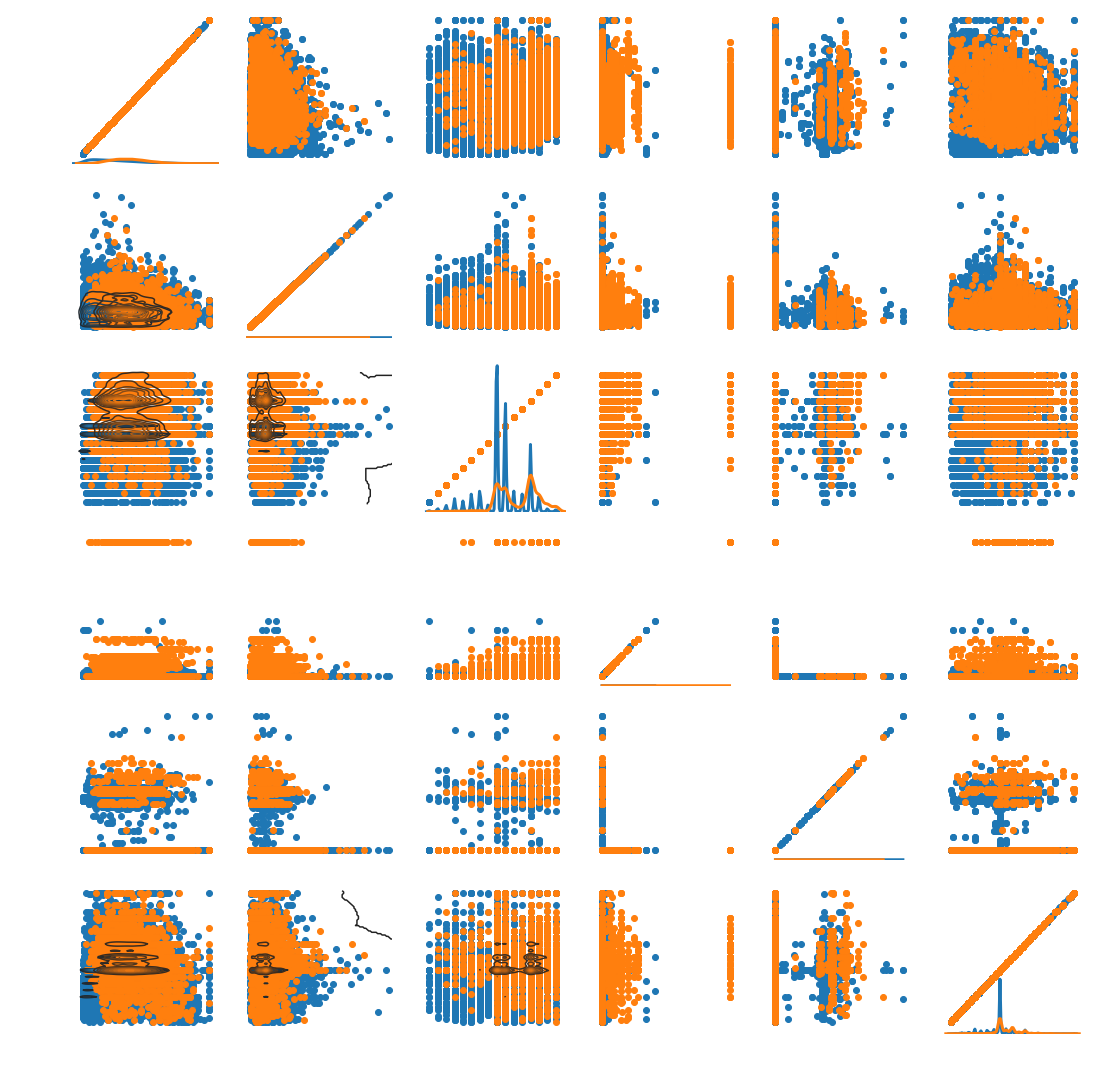

In [591]:
# Categorical plots
# TODO: https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial

# Numeric plots:
# TODO: https://seaborn.pydata.org/tutorial/axis_grids.html#grid-tutorial

# Statistical relationships with data
# TODO: https://seaborn.pydata.org/tutorial/relational.html#relational-tutorial
g = sns.PairGrid(df, hue="loan")
g.map(plt.scatter);

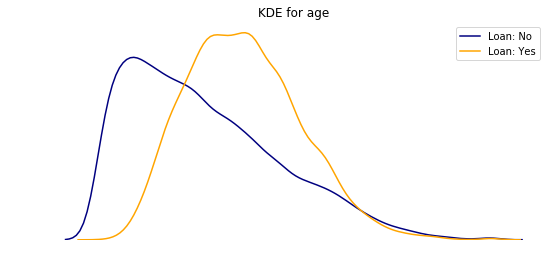

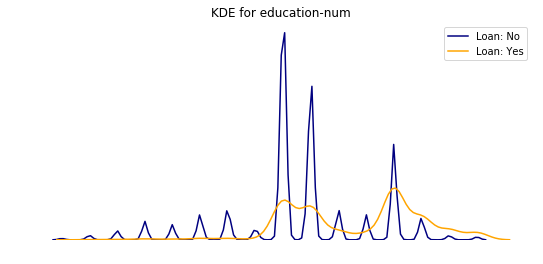

In [566]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['loan'] == ' <=50K'][feature].dropna(), color= 'navy', label= 'Loan: No')
    ax1 = sns.kdeplot(df[df['loan'] == ' >50K'][feature].dropna(), color= 'orange', label= 'Loan: Yes')
kdeplot('age')
kdeplot('education-num')